# Building Text Similarity

In [1]:
NUM_ROWS = 1000

# Initialization

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
import wikipedia

In [3]:
import pandas as pd
import random
random.seed(1)

In [4]:
import requests

In [5]:
import numpy as np

# Read Data

## WikiSummaries - Fetch from Wikipedia API

Fetching articles manually from wikipedia api

`
article_ids = [
    'Adam_Smith','Bill_Clinton','Bill_Gates','Economics','Free_market'
]
article_summaries = [wikipedia.summary(artId) for artId in dfPageLinks.title]
`

How to read csv file into pandas manually.
Found a better way to read subset file into pandas.. 

`
f = open("sdow/database/subset_summaries.csv", "r")
arrLines = []
for line in f.readlines()[:20]:
    print(line)
    arrLines.append(re.split("(^\d+) ", line))
f.close()
`

In [6]:
def fetchSummariesForIds_step(ids):
    api_request = { "action" : "query", "pageids" : '|'.join(ids), "prop" : "extracts", "exintro" : "", "explaintext" : "", "format" : "json" }

    # Making the query and storing the result in a dict from the JSON formatted response
    r = requests.get('https://en.wikipedia.org/w/api.php', params=api_request)
    requests_dict = r.json()
    
    dfTmp = pd.DataFrame(requests_dict['query']['pages']).T
    dfTmp = dfTmp.drop('ns', axis=1).reset_index(drop=True)
    dfTmp.columns = ['id','title','summary']
    
    return dfTmp

def fetchSummariesForIds(ids):
    pagedIds = [ids[i:i+20] for i in range(0, len(ids), 20)]
    dfs = []
    for arr in pagedIds:
        dfs.append(fetchSummariesForIds_step(arr))
    return pd.concat(dfs).reset_index(drop=True)

## WikiSummaries - Read from CSV file

In [7]:
# Expected CSV format : 
!head -n1 'sdow/database/subset_summaries.csv'

In [8]:
dfSummaries = pd.read_csv('sdow/database/subset_summaries.csv', nrows=NUM_ROWS, sep=" ", header=None, names=['id','title','summary'])
display(dfSummaries.shape)
dfSummaries

(403, 3)

id                                              title  \
0        1814                                         Adam_Smith   
1        3356                                       Bill_Clinton   
2        3747                                         Bill_Gates   
3        8182                               Dwight_D._Eisenhower   
4        9223                                          Economics   
..        ...                                                ...   
398  38195450  List_of_personal_coats_of_arms_of_presidents_o...   
399  38777001                   Socialist_Labor_Party_of_America   
400  43441278            Socialist_Workers_Party_(United_States)   
401  45239953                                     Freedom_Caucus   
402  60776216                    Republican_Party_of_Puerto_Rico   

                                               summary  
0    Adam Smith  (16 June [O.S. 5 June] 1723 – 17 J...  
1    William Jefferson Clinton (born William Jeffer...  
2    William Henry Gates III  (born October 28, 195...  
3    Dwight David "Ike" Eisenhower ( EYE-zən-how-ər...  
4    Economics () is the social science that studie...  
..                                                 ...  
398  Many United States presidents have borne a coa...  
399  The Socialist Labor Party (SLP) is the oldest ...  
400  The Socialist Workers Party (SWP) is known as ...  
401  The Freedom Caucus, also known as the House Fr...  
402  The Republican Party of Puerto Rico (Spanish: ...  

[403 rows x 3 columns]

## Read PageLinks - Local SQLite3

In [9]:
import sqlite3

sdow_database='./sdow/sdow/sdow.sqlite'
sdow_conn = sqlite3.connect(sdow_database, check_same_thread=False)
sdow_cursor = sdow_conn.cursor()

SQLite Commands : https://www.sqlitetutorial.net/sqlite-tutorial/sqlite-show-tables/

`sqlite3 ./sdow/sdow.sqlite`

`
sqlite> .tables
links      pages      redirects
`

### How to Execute Raw Query

In [10]:
query = 'SELECT count(*) FROM pages;'
sdow_cursor.execute(query)
results = sdow_cursor.fetchall()

In [11]:
results

[(14859632,)]

In [12]:
NUM_LINKS = 70
query = 'SELECT id FROM links WHERE outgoing_links_count>{} AND incoming_links_count>{} LIMIT {};'.format(NUM_LINKS, NUM_LINKS, NUM_ROWS)
sdow_cursor.execute(query)
starter_ids = sdow_cursor.fetchall()
starter_ids = np.array(starter_ids).flatten()

### Read SQLite3 PageLink Data into Pandas

In [13]:
dfPages = pd.DataFrame()
dfPagesInd = pd.DataFrame()

def fetchPageLinksDf(pageIds):
    pageIdsStr = str(tuple(pageIds)).replace(',)', ')')
    dfPageLinks = pd.read_sql_query("SELECT * FROM pages JOIN links on pages.id=links.id where pages.id in {} limit {}".format(
    pageIdsStr,NUM_ROWS), sdow_conn)
    display(dfPageLinks.shape)

    # drop the annoying duplicate 'id' column, and cast to str
    dfPageLinks = dfPageLinks.iloc[:,1:]
    dfPageLinks.id = dfPageLinks.id.astype(str)
    return dfPageLinks

def fetchPagesDf(pageIds):
    missing_ids = pd.Series(pageIds)[~(pd.Series(pageIds).isin(dfPagesInd.index))]
    dfPageLinks = fetchPageLinksDf(pageIds)
    dfSummaries = fetchSummariesForIds(pageIds)
    dfSummaries.id = dfSummaries.id.astype(str)

    # unify dataframes
    dfPagesSub = pd.merge(dfPageLinks, dfSummaries, on='id', suffixes=("","_y"), ) #.drop_duplicates(subset='id', keep='last')

#     dfPages = pd.concat([dfPages, dfPagesSub])
#     dfPagesInd = dfPages.reset_index().set_index('id')

    return dfPagesSub

def fetchOutgoingPagesForPage(pageRow):
    return fetchPagesDf(pageRow.outgoing_links.split('|'))

dfPages = fetchPagesDf(starter_ids.astype(int).astype(str))
dfPagesInd = dfPages.reset_index().set_index('id')

(1000, 8)

# Train/Run PageLink 'Recommender'

In [14]:
tfidf_vectorizer = TfidfVectorizer()
matTfidf = tfidf_vectorizer.fit_transform(dfPagesInd.summary)
pairwise_similarity = matTfidf * matTfidf.T

In [15]:
pd.DataFrame(pairwise_similarity.toarray()[:100,:100]).style.background_gradient()

## Score Outgoing Pages (TF-IDF + PairwiseSim)

In [16]:
def score_outgoinglinks(current, target):
#     print (current, target)
    # get tfidf indices of target_article outgoing_link_pages from current_page
    targetColNum = dfPagesInd.loc[target]['index']-1
    arrOutgoingLinks = dfPagesInd.loc[current].outgoing_links.split('|')
    dfOutgoingPages = dfPagesInd.reindex(arrOutgoingLinks).dropna()
    arrOutgoingInds = dfOutgoingPages['index'].astype(int).to_list()
#     print(targetColNum, arrOutgoingInds)

    # fetch those values from similarity matrix
    arrLinkSims = pairwise_similarity.getcol(targetColNum)[arrOutgoingInds].toarray().flatten()

    # add to df
    dfOutgoingPages['score'] = arrLinkSims
    return dfOutgoingPages.sort_values('score', ascending=False)[['title','score', 'summary']]

In [17]:
def pageTitleToId(title):
    return dfPagesInd[dfPagesInd.title == title].index.values[0]
def pageIdToTitle(pageId):
    return dfPagesInd.loc[pageId].title

### Sample Run

In [18]:
def fetchPagesForIds(ids) :
    dfTmpLinks = fetchPageLinksDf(ids)
    dfTmpSummaries = fetchSummariesForIds(ids)

    dfTmpSummaries.id = dfTmpSummaries.id.astype(str)
    # unify dataframes
    dfTmpPages = pd.merge(dfTmpLinks, dfTmpSummaries, on='id', suffixes=("","_y"), ).drop_duplicates(subset='id', keep='last')
    return dfTmpPages

## Navigate Links Searching for Page

In [19]:
dfPages.sample(5)

title  is_redirect       id  \
280                                            Salmiya            0   219337   
915                               Rippleside,_Victoria            0  1519938   
646  Rowing_at_the_2004_Summer_Olympics_–_Women\'s_...            0   987538   
518                                   Paul_W._Richards            0   656291   
215                Russell,_Bayfield_County,_Wisconsin            0   138724   

     outgoing_links_count  incoming_links_count  \
280                    83                    71   
915                    80                    71   
646                    89                    71   
518                    84                    71   
215                    93                    71   

                                        outgoing_links  \
280  12240|13979122|14465556|1474511|1536171|154968...   
915  1106744|1121922|1224986|12455087|13531580|1458...   
646  11032917|1148937|1216|13030812|15929080|186627...   
518  10485878|1195068|132836|132862|13403480|135504...   
215  1094495|11113|1175083|128608|138704|138705|138...   

                                        incoming_links  \
280  10157508|11486186|13979122|14238661|14359944|1...   
915  1121922|1224986|12455087|12838567|13531580|145...   
646  11032917|1154762|13030812|13156275|18662704|18...   
518  10485878|12381157|12588445|12952595|132836|136...   
215  10630963|1094495|1175083|138704|138705|138706|...   

                                               title_y  \
280                                            Salmiya   
915                               Rippleside, Victoria   
646  Rowing at the 2004 Summer Olympics – Women's l...   
518                                   Paul W. Richards   
215                Russell, Bayfield County, Wisconsin   

                                               summary  
280  Salmiya (Arabic السالمية; transliterated As-Sā...  
915  Rippleside is a suburb of Geelong, Victoria, A...  
646  These are the results of the Women's lightweig...  
518  Paul William Richards (born May 20, 1964 in Sc...  
215  Russell is a town in Bayfield County, Wisconsi...

In [20]:
def race_loop(startId, targetId, nstop=7):
    currentId = startId
    dfOutgoingPages = dfPagesInd.loc[[startId, targetId]]
    startTitle = dfOutgoingPages.iloc[0].title
    targetTitle = dfOutgoingPages.iloc[1].title
    arrVisited = []    
    
    print('--- Let the race begin! ---')
    print('Start : ', startId, startTitle)
    print('Target : ', targetId, targetTitle)
#     print('StartId :',startId, ' - TargetId:',targetId)
#     print('StartTitle :',startTitle, ' - TargetTitle:',targetTitle)


    itr = 0
    while currentId != targetId and itr < nstop:
        currentTitle = dfOutgoingPages.iloc[0].title
        print(itr, currentTitle, targetTitle)
        dfOutgoingPages = fetchOutgoingPagesForPage(dfOutgoingPages.iloc[0])

        targTfidf = tfidf_vectorizer.transform(dfPagesInd.loc[[targetId]].summary)
        matTfidf = tfidf_vectorizer.transform(dfOutgoingPages.summary)

        target_similarity = matTfidf * targTfidf.T
        dfOutgoingPages['score'] = target_similarity.toarray().flatten()
        dfOutgoingPages = dfOutgoingPages.sort_values('score',ascending=False)
        
        ## update state vars
        arrVisited.append(currentId)
        currentId = dfOutgoingPages[~dfOutgoingPages.id.isin(arrVisited)].iloc[0].id
        itr += 1

    if itr<nstop:
        print('Success! From ', startId, 'to', targetId, 'in {} hops!'.format(itr))
    else:
        print('Early stopping, too many steps')

In [21]:
startId = dfPages.sample(1).id.values[0]
targetId = dfPages.sample(1).id.values[0]
# startId = '310025'
# targetId = '1134507'

race_loop(startId, targetId)

--- Let the race begin! ---
Start :  122870 Winfield,_Missouri
Target :  1589541 Michael_Aldridge
0 Winfield,_Missouri Michael_Aldridge


(99, 8)

1 1990_United_States_Census Michael_Aldridge


(219, 8)

2 Bill_Cosby Michael_Aldridge


(861, 8)

3 Ed_Asner Michael_Aldridge


(406, 8)

4 Tom_Poston Michael_Aldridge


(134, 8)

5 Ed_Asner Michael_Aldridge


(406, 8)

6 Tom_Poston Michael_Aldridge


(134, 8)

Early stopping, too many steps


# Calc Number Steps (breadth first)

In [22]:
# requires server is running..
import requests

BF_SEACH_SERVER = 'http://localhost:5000'
AI_SERVER = 'http://localhost:5001'

In [23]:

# params = {"source":currentTitle, "target":targetTitle}
params = {"source":"Slabtown,_Pennsylvania", "target":"Jews_for_Jesus"}

resp = requests.post(url=BF_SEACH_SERVER+'/paths', json=params)
display(resp)
data = resp.json() # Check the JSON Response Content documentation below

<Response [200]>

In [24]:
data['paths']

[[132164, 19728, 25031, 66543],
 [132164, 23332, 25031, 66543],
 [132164, 132088, 25031, 66543]]

`
for rows
    for columns
        add row to df current pageId and tagetId and score (ie number of columns apart)
        ie  row  [currentPageId, targetId, distance]
make rows unique
for each current pageId row add the rest (or some) of the page links with large distance

replace pageIds with vectorRepresentations. 
 -either concat or add/subtract/multiply the representations together
train classifier
`
---------
`
perhaps compute in opposite direction??
- start with target and keep iterating outwards and create the dataframe that way
`

# Build BaseLine Model

## Build Regression dfTrain -- 'distance' from targetPage

In [25]:
def getBuildStepMerge(dfTrain, num):
    dfTmpPages = fetchPageLinksDf(dfTrain.sample(num).sourceId)

    dfTmp = dfTmpPages.set_index('id').incoming_links.str.split('\|', expand=True).stack().reset_index()
    dfTmp = dfTmp.drop('level_1', axis=1)
    dfTmp.columns = ['targetId','sourceId']

    dfTmpMerge = pd.merge(dfTrain, dfTmp, left_on='sourceId', right_on='targetId')
    return dfTmpMerge

def buildTrainWide(dfTrain, num=2):
    dfTmpMerge = getBuildStepMerge(dfTrain, num)
    dfTmpMerge.distance = 1
    dfTmpMerge = dfTmpMerge[['sourceId_x', 'sourceId_y', 'distance']]
    dfTmpMerge.columns = ['targetId', 'sourceId', 'distance']
    return dfTmpMerge
    
def buildTrainDown(dfTrain, num=2):
    dfTmpMerge = getBuildStepMerge(dfTrain, num)
    dfTmpMerge.distance += 1
    dfTmpMerge = dfTmpMerge[['targetId_x', 'sourceId_y', 'distance']]
    dfTmpMerge.columns = ['targetId', 'sourceId', 'distance']
    return dfTmpMerge

def removeDuplicatesTrain(dfTrain):
    return dfTrain.groupby(['targetId','sourceId']).distance.min().reset_index()

In [26]:
# init dfTrain
dfTrain = pd.DataFrame(dfPagesInd.sample(2).index.values)

dfTrain['targetId'] = dfTrain[0]
dfTrain['sourceId'] = dfTrain[0]
dfTrain['distance'] = 0

dfTrain = dfTrain.drop(0, axis=1)

In [27]:
dfTrain = dfTrain.append(buildTrainDown(dfTrain))
dfTrain = dfTrain.append(buildTrainDown(dfTrain))
dfTrain = dfTrain.append(buildTrainDown(dfTrain))
dfTrain = dfTrain.append(buildTrainDown(dfTrain))
dfTrain = removeDuplicatesTrain(dfTrain)
dfTrain = dfTrain.append(buildTrainWide(dfTrain))
dfTrain = dfTrain.append(buildTrainWide(dfTrain))
dfTrain = dfTrain.append(buildTrainDown(dfTrain))
dfTrain = dfTrain.append(buildTrainWide(dfTrain))
dfTrain = dfTrain.append(buildTrainDown(dfTrain))
dfTrain = removeDuplicatesTrain(dfTrain)

(2, 8)

(2, 8)

(2, 8)

(2, 8)

(2, 8)

(2, 8)

(2, 8)

(2, 8)

(2, 8)

## View Properties of dfTrain

In [28]:
display(dfTrain.shape)
dfTrain.sample(5)

(3083, 3)

targetId  sourceId  distance
1092   2334023  38360095         1
1105   2334023  39230759         2
2243  33244435  43521951         2
2049  33244435    306723         1
2897    880212   2033080         1

In [29]:
dfTrain.distance.value_counts()

1    2382
2     643
3      56
0       2
Name: distance, dtype: int64

## Fetch Summaries for these pages

In [59]:
arrPageIds = np.unique(np.array([dfTrain.targetId.astype(str).values, dfTrain.sourceId.astype(str).values]).flatten())

In [60]:
dfTrainPages = fetchPagesDf(arrPageIds[:800])

(800, 8)

In [61]:
dfTrainPagesInd = dfTrainPages.reset_index().set_index('id')

In [62]:
dfTrainPages.head(25)

title  is_redirect      id  outgoing_links_count  \
0                            ICC            0   14881                    80   
1               Orlando,_Florida            0  100582                  1127   
2             Anniston,_Missouri            0  122916                    81   
3             Bertrand,_Missouri            0  122917                    83   
4           Charleston,_Missouri            0  122918                   252   
5          Wilson_City,_Missouri            0  122919                    76   
6                Wyatt,_Missouri            0  122920                    84   
7         East_Prairie,_Missouri            0  124790                   101   
8              Pinhook,_Missouri            0  124791                    72   
9                    Thermopylae            0  145088                   498   
10             Shaquille_O\'Neal            0  147726                  1743   
11               Miner,_Missouri            0  150757                   115   
12            Sikeston,_Missouri            0  150759                   351   
13              Carlos_Colón_Sr.            0  155498                   321   
14                Dwayne_Johnson            0  156126                  1078   
15         Battle_of_Thermopylae            0  157446                   261   
16    Don_King_(boxing_promoter)            0  158351                   196   
17                 Bruiser_Brody            0  158716                   319   
18                 San_Theodoros            0  169512                   159   
19                    Tito_Ortiz            0  169662                   247   
20                  Stripperella            0  185007                   626   
21  World_Championship_Wrestling            0  186694                   631   
22                  Miss_America            0  194034                   581   
23  List_of_one-word_stage_names            0  203182                  3009   
24                      Bob_Sapp            0  204196                   386   

    incoming_links_count                                     outgoing_links  \
0                      3  11391832|11522560|12563163|1344560|1403791|147...   
1                  11051  100582|100627|1010443|1016696|1019194|102024|1...   
2                     47  103733|11113|122917|122918|122919|122920|12479...   
3                     50  11113|122916|122918|122919|122920|124790|12479...   
4                    245  104690|11113|112641|11533006|11948192|1224478|...   
5                     43  110805|11113|122916|122917|122918|122920|12479...   
6                     45  11113|122916|122917|122918|122919|124790|12479...   
7                     71  11113|122916|122917|122918|122919|122920|12295...   
8                     44  110805|11113|122916|122917|122918|122919|12292...   
9                    242  1005748|10073|10074|1014273|1028|1033564|10377...   
10                  2352  1000246|10032794|1003449|1004372|100582|100747...   
11                    98  11113|122916|122917|122918|122919|122920|12311...   
12                   287  10346754|1048768|110805|11113|1117944|11367646...   
13                   317  1002441|1008932|101568|1019157|1024548|1041015...   
14                  1579  10003087|1002441|100571|100796|10159631|101733...   
15                   303  10017071|10074|10075|10255756|103030|10377130|...   
16                   368  10041734|102226|1041909|1053905|10569267|10724...   
17                   379  1002441|1008932|1024548|1041577|1045788|106931...   
18                   103  10014777|1008213|10375042|10516656|1092739|112...   
19                   272  1001882|101733|102227|10524625|106211|1072241|...   
20                   592  10022375|10022476|10024689|10028074|10028428|1...   
21                  2212  1002380|1002441|10125535|1015304|1027406|10435...   
22                  1472  1006407|10071|1007192|1007667|1009303|10118007...   
23                   193  1003976|10042030|1005113|10074446|10075415|100... 

In [63]:
tfidf_vectorizer = TfidfVectorizer(strip_accents='ascii', min_df=0.01, max_df=0.3, max_features=100)
matTfidf = tfidf_vectorizer.fit_transform(dfTrainPages.summary)
pairwise_similarity = matTfidf * matTfidf.T

In [64]:
pd.DataFrame(pairwise_similarity.toarray()[:100,:100]).style.background_gradient()

In [65]:
dfTmp = pd.merge(dfTrain, dfTrainPagesInd[['index']], how='left', left_on='targetId', right_index=True).rename(columns={'index':'target_index'})
dfTmp = pd.merge(dfTmp, dfTrainPagesInd[['index']], how='left', left_on='sourceId', right_index=True).rename(columns={'index':'source_index'})
beforeLen = len(dfTmp)
dfTmp = dfTmp.dropna()
print('Dropped NA Training (original/reduced)', beforeLen, '/', len(dfTmp))
dfTmp

Dropped NA Training (original/reduced) 3083 / 473


targetId  sourceId  distance  target_index  source_index
0     124790  10118007         2           7.0         452.0
1     124790  10568255         2           7.0         464.0
2     124790  10925692         2           7.0         475.0
3     124790  11294116         2           7.0         500.0
4     124790  12005290         2           7.0         520.0
..       ...       ...       ...           ...           ...
791  2334023   2323650         1         446.0         444.0
792  2334023   2330656         1         446.0         445.0
793  2334023  23316800         1         446.0         799.0
794  2334023   2334023         1         446.0         446.0
795  2334023   2334053         1         446.0         447.0

[473 rows x 5 columns]

In [66]:
matTfidf[dfTmp.source_index.astype(int)]

<473x100 sparse matrix of type '<class 'numpy.float64'>'
	with 7558 stored elements in Compressed Sparse Row format>

In [67]:
matTrainTfidf = np.hstack([matTfidf[dfTmp.target_index.astype(int)].toarray(), matTfidf[dfTmp.source_index.astype(int)].toarray()])

In [68]:
matTrainTfidf.shape

(473, 200)

## Train Baseline Regressor

In [85]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [70]:
from sklearn.preprocessing import StandardScaler

In [71]:
X = matTrainTfidf
y = dfTmp.distance

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Run BaseLine Approaches

In [72]:
## shuffle the test values
preds = pd.Series(y_test).sample(frac=1)
print('Predicting Random : ', mean_absolute_error(preds, y_test))

## Predict specific numbers
preds = np.ones_like(y_test)*1
print('Predicting {} : '.format(1), mean_absolute_error(preds, y_test))

preds = np.ones_like(y_test)*2
print('Predicting {} : '.format(2), mean_absolute_error(preds, y_test))

preds = np.ones_like(y_test)*3
print('Predicting {} : '.format(3), mean_absolute_error(preds, y_test))

Predicting Random :  0.24203821656050956
Predicting 1 :  0.14012738853503184
Predicting 2 :  0.8726114649681529
Predicting 3 :  1.872611464968153


## Pairwise

### Train the Distribution Functions (StandardScaler)

In [73]:
X_train.shape

(316, 200)

In [74]:
tfidf_wordCount = len(tfidf_vectorizer.get_feature_names())

a = X_train[:,:tfidf_wordCount]
b = X_train[:,tfidf_wordCount:]
pairwise_sims = np.matrix(a)*np.matrix(b).T

In [75]:
pairwise_dist = StandardScaler()
distance_dist = StandardScaler()

In [76]:
distance_dist.fit(y_train.to_frame().values)
pairwise_dist.fit(
    pairwise_sims.diagonal().reshape(-1,1)
)

StandardScaler(copy=True, with_mean=True, with_std=True)

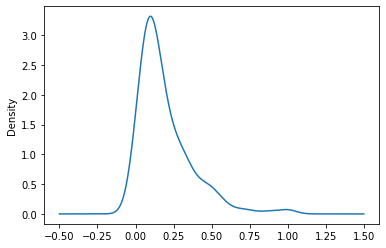

In [77]:
pd.Series(np.array(pairwise_sims.diagonal())[0]).plot.density()

In [78]:
a = X_test[:,:tfidf_wordCount]
b = X_test[:,tfidf_wordCount:]
preds_pairwise_sims = np.matrix(a)*np.matrix(b).T

### Compute Pairwise Similarities --> transform to output dist

In [79]:
y_pairwise = distance_dist.inverse_transform(
    pairwise_dist.transform(preds_pairwise_sims.diagonal().reshape(-1,1)).flatten()
)

array([1.18944659, 1.11501299, 0.96753365, 1.07885555, 0.80736583,
       1.01693014, 1.03618312, 2.34916568, 1.00058408, 0.78150694,
       1.07228468, 0.89931093, 0.94524906, 0.92415783, 0.98413841,
       0.87084938, 0.91941403, 1.21134049, 0.94098077, 1.57762782,
       0.78150694, 0.94828129, 2.34916568, 1.02676056, 1.08684786,
       0.93817641, 0.86353989, 0.78150694, 0.78150694, 0.99941253,
       0.90076254, 0.89732925, 1.38834812, 0.78150694, 0.91221298,
       1.04830307, 1.17939031, 1.14529412, 0.97754505, 1.20612031,
       0.98002246, 0.84192351, 0.86934726, 0.96734598, 0.97134695,
       1.07279051, 1.16763783, 1.6394074 , 0.85167562, 0.98615582,
       0.95988342, 1.14728484, 0.98903992, 0.97477441, 1.0887896 ,
       0.83753554, 1.27113802, 0.96331846, 1.11561234, 1.24462354,
       0.89986535, 0.82211924, 1.04812739, 1.24437756, 1.18902942,
       0.97588596, 1.21587646, 0.86381096, 1.14969126, 0.96138958,
       1.1932703 , 0.88428474, 1.03073523, 0.91800538, 1.78213

### Score Predictions

In [80]:
preds = y_pairwise
print('Predict Pairwise : ', mean_absolute_error(preds, y_test))

Predict Pairwise :  0.30528895411596335


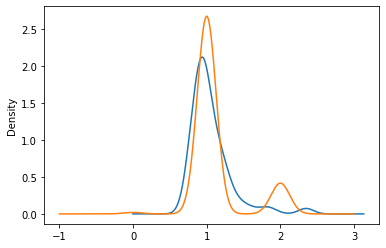

In [81]:
pd.Series(preds).plot.density()
pd.Series(y_test).plot.density()

## RandomForest Regressor

In [82]:
regr = RandomForestRegressor(random_state=0, n_estimators=100, oob_score=True)
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=True, random_state=0, verbose=0,
                      warm_start=False)

In [83]:
preds = regr.predict(X_test)
mean_absolute_error(preds, y_test)

0.14146496815286624

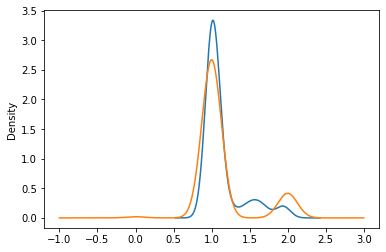

In [84]:
pd.Series(preds).plot.density()
pd.Series(y_test).plot.density()

## RandomForest Classifier

In [87]:
regr = RandomForestClassifier(random_state=0, n_estimators=100, oob_score=True)
regr.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

In [88]:
preds = regr.predict(X_test)
mean_absolute_error(preds, y_test)

0.09554140127388536

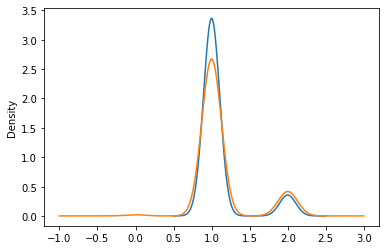

In [89]:
pd.Series(preds).plot.density()
pd.Series(y_test).plot.density()

# UMLFit --> sklearn lgbm

[NLP-ENCODE(textTargetPage), NLP-ENCODE(textLinkedPage)] --> NN <> score_for_link_given_the_target